In [1]:
#@title
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

#from scipy.special import softmax
#from sklearn.model_selection import train_test_split


In [2]:
#add the  bayesiancnnn and ensai src to import path - https://stackoverflow.com/a/35273613/7154530
bcnn_module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if bcnn_module_path not in sys.path:
    sys.path.append(bcnn_module_path)
    
ensai_module_path = os.path.abspath(os.path.join('../ensai'))
if ensai_module_path not in sys.path:
    sys.path.append(ensai_module_path)

In [3]:
from BBBlayers import GaussianVariationalInference
from BayesianModels.BayesianAlexNet import BBBAlexNet


In [4]:
num_out = 5    #number ouf output parameters being predicted
global numpix_side
numpix_side = 192   #number of image pixels on the side
global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)


cycle_batch_size = 50   # how many examples to read at a time (here it's equal to the batch size)
num_test_samples = 1000 # number of test samples

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2

global min_unmasked_flux
min_unmasked_flux = 0.75

global num_data_dirs
num_data_dirs = 3

num_training_samples = 100000
max_num_test_samples = 10000
arcs_data_path_1 = '../../data/ensai/SAURON_TEST/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1
test_data_path_1 = '../../data/ensai/SAURON_TEST/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = '../../data/ensai/SAURON_TEST/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1
testlens_data_path_1 = '../../data/ensai/SAURON_TEST/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

CRay_data_path   = '../../data/ensai/CosmicRays/'
ps_data_path = '../../data/ensai'

arcs_data_paths = [arcs_data_path_1, arcs_data_path_2, arcs_data_path_3]
test_data_paths = [test_data_path_1, test_data_path_2, test_data_path_3]
lens_data_paths = [lens_data_path_1, lens_data_path_2, lens_data_path_3]
testlens_data_paths = [testlens_data_path_1, testlens_data_path_2, testlens_data_path_3]

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

restore_file = "../../data/ensai/trained_weights/model_9.ckpt"

In [97]:
#@title
#net_type = 'houses-bnn'
#dataset = 'houses'
net_type = 'alexnet'
dataset = 'stronglens'
outputs = num_out
inputs = 1
regression = True
resume = False
start_epoch = 0
n_epochs = 1000 #set to 10 for MNIST, 30 for cifar10, and 200 for house pricing
lr = 0.001
weight_decay = 0.0005
num_samples = 10
beta_type = "Blundell"
resize=32
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256
# percentage of training set to use as validation
valid_size = 0.2
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = []
output_names = ['Einstein Radius', 'Ellipticity (x)', 'Ellipticity (y)', 'Center(x)', 'Center (y)']

In [98]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

In [99]:
from get_data import DataProcessor

In [100]:
dataproc = DataProcessor(ps_data_path, arcs_data_paths, lens_data_paths,
                              test_data_paths, 
                              testlens_data_paths,
                              CRay_data_path, numpix_side, 
                              max_noise_rms,
                              max_psf_rms, max_cr_intensity, 
                              variable_noise_rms, pix_res, 
                              min_unmasked_flux, num_data_dirs,
                              max_xy_range, num_out)

In [101]:
def apply_transform(tensor, transform=None):
    #print(tensor.shape)
    img = TF.to_pil_image(tensor)
    img = transform(img)
    return TF.to_tensor(img)

In [102]:
transform_train = transforms.Compose([
    transforms.Resize((resize, resize))
])  

transform_test = transforms.Compose([
    transforms.Resize((resize, resize))
])

In [103]:
# read some lens image files from the disk and add observational effects to them:

max_xy_range = 0.5  # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
variable_noise_rms = True   #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms
max_noise_rms = 0.1  # maximum rms of noise data
num_samp = 6000   #number of samples
chunk_size = batch_size    # batch number: how many test examples to pass at one time.

'''trainX = np.zeros( ( num_samp , numpix_side * numpix_side ), dtype='float32') ;   #numpy array holding the images
trainY = np.zeros( ( num_samp , num_out ) , dtype='float32' );                    #numpy array holding the lens parameters (here only used to flip for the x-y ellipticity)
trainMag = np.zeros((num_samp,1))
dataproc.read_data_batch( trainX , trainY , trainMag , num_training_samples  , 'train')             #read data
'''
X = np.zeros( ( num_samp , numpix_side * numpix_side ), dtype='float32') ;   #numpy array holding the images
Y = np.zeros( ( num_samp , num_out ) , dtype='float32' );                    #numpy array holding the lens parameters (here only used to flip for the x-y ellipticity)
mag = np.zeros((num_samp,1))
dataproc.read_data_batch( X , Y , mag , 15000  , 'test')             #read data

In [104]:
trainX = X[:5000, :].reshape(-1, numpix_side, numpix_side)
trainY = Y[:5000, :].reshape(-1, num_out)

testX = X[5000:, :].reshape(-1, numpix_side, numpix_side)
testY = Y[5000:, :].reshape(-1, num_out)

tensor_x_train = torch.stack([apply_transform(torch.Tensor(i), transform_train) for i in trainX]) # transform to torch tensors
tensor_y_train = torch.stack([torch.Tensor(i) for i in trainY])
trainset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset

tensor_x_test = torch.stack([apply_transform(torch.Tensor(i), transform_test) for i in testX]) # transform to torch tensors
tensor_y_test = torch.stack([torch.Tensor(i) for i in testY])
testset = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [105]:
len(X)

6000

In [106]:
# removing image intensity bias: filter image with a 4X4 filter and remove from image
def remove_image_intensity_bias(x):
    #print(x)
    MASK = torch.abs(torch.sign(x))
    XX =  x +  ( (1-MASK) * 1000.0)
    #print(XX)
    bias_measure_filt = torch.full((1, 1, 4, 4), 1/16.0)
    bias_measure = F.conv2d(input=XX , weight=bias_measure_filt , stride=1, padding=0)
    im_bias = torch.reshape(bias_measure.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0].min(dim=3, keepdim=True)[0] , [-1,1,1,1])
    return x - (im_bias * MASK )

In [107]:
#remove_image_intensity_bias(Variable(torch.Tensor(X[0]).reshape(1, 1, 192, 192)))

In [114]:
net = BBBAlexNet(outputs,inputs)
if use_cuda:
    net.cuda()

loss = torch.nn.MSELoss()
vi = GaussianVariationalInference(loss, log=True)

#logfile = os.path.join('diagnostics_Bayes{}_{}.txt'.format(net_type, dataset))

In [115]:
#Pretty print estimates
def pp_estimates(names, confidence_mean, confidence_var, epistemic, aleatoric, tag='Parameter'):
    print('\n\n----------------------------------------------------------------------------------------------\n')
    print(    '|{:>15s}| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |\n'.format(tag))
    print(    '----------------------------------------------------------------------------------------------\n')
    for i in range(len(names)):
        print('|{:>15s}|{:>17.4f}|{:>10.4f}|{:>23.4f}|{:>23.4f}|\n'.format(names[i], confidence_mean[i], confidence_var[i], epistemic[i], aleatoric[i]))
    print(    '----------------------------------------------------------------------------------------------\n\n')
    

In [116]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 160):
        optim_factor = 3
    elif(epoch > 120):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [117]:
#@title
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate(lr, epoch), weight_decay=weight_decay)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader): 
        x = inputs_value.view(-1, inputs, resize, resize)
        x_nobias = remove_image_intensity_bias(x)
        x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)
        #print(x.shape, y.shape, outs.shape)
        #print(outs)
        #print(y)
        loss = vi(outs, y, kl, beta)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                (len(trainset)//batch_size)+1, loss, train_loss))
        sys.stdout.flush()
    
    return train_loss

In [118]:
#@title 
def test(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions=[]
    means = []
    variances = []
    epistemics = []
    aleatorics = []
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        x = inputs_value.view(-1, inputs, resize, resize)
        x_nobias = remove_image_intensity_bias(x)
        x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs, kl, mus, sigmas = net.probforward(x, ret_mean_std=True)
        #print(mns)
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0

        loss = vi(outs, y, kl, beta)

        test_loss += loss.data.item()
        loss = loss.data.item()
        preds = outs
        results = preds.cpu().detach().numpy() #.data.mean(dim=0) #torch.topk(preds.cpu().data, k=1, dim=0)
        confidence_mean = np.mean(results, axis=0)
        confidence_var = np.var(results, axis=0)
        mus = mus.cpu().detach().numpy()
        sigmas = sigmas.cpu().detach().numpy() ** 2 
        epistemic = np.mean(mus ** 2, axis=0) - np.mean(mus, axis=0) ** 2
        aleatoric = np.mean(sigmas, axis=0)
        
        means.append(confidence_mean)  
        variances.append(confidence_var)
        epistemics.append(epistemic)
        aleatorics.append(aleatoric)

    # Save checkpoint when best model
    confidence_mean = np.mean(means, axis=0)
    confidence_var = np.mean(variances, axis=0)
    epistemic = np.mean(epistemics, axis=0)
    aleatoric = np.mean(aleatorics, axis=0)
    #print(confidence_mean, confidence_var, epistemic, aleatoric)
    print('\n| Validation Epoch #%d'%(epoch))
    pp_estimates(output_names, confidence_mean, confidence_var, epistemic, aleatoric)
    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if save_epoch:
       if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
       
       save_point = './checkpoint/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if test_loss < best_loss:
        print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
        best_loss = test_loss
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    return test_loss

In [119]:
#@title
elapsed_time = 0
saved_epochs = []

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(start_epoch, start_epoch+n_epochs):
    start_time = time.time()

    tloss = train(epoch)
    train_losses.append(tloss)
    if (epoch%1 == 0):
        vloss = test(epoch, save_epoch = True )
        saved_epochs.append(epoch)
    else:
        vloss = test(epoch)
        val_losses.append(vloss)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

print('\n Test results : Loss = %.2f' %(best_loss))


=> Training Epoch #0, LR=0.0010
| Epoch [  0/999] Iter[ 20/ 20]		Iter Loss: 0.7723, Cumulative Loss: 1230331.733031009
| Validation Epoch #0


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.1076|    0.2833|                 0.0160|                 0.2702|

|Ellipticity (x)|          -0.0072|    0.1952|                 0.0116|                 0.1867|

|Ellipticity (y)|          -0.0596|    0.2086|                 0.0130|                 0.2108|

|      Center(x)|          -0.1527|    0.2368|                 0.0137|                 0.2312|

|     Center (y)|          -0.0496|    0.2454|                 0.0131|                 0.2261|

----------------------------------------------------------------------------------------

| Epoch [  8/999] Iter[ 20/ 20]		Iter Loss: -0.5444, Cumulative Loss: 1161342.22931990
| Validation Epoch #8


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.3744|    0.0192|                 0.0024|                 0.0194|

|Ellipticity (x)|           0.0476|    0.0091|                 0.0011|                 0.0079|

|Ellipticity (y)|           0.0216|    0.0096|                 0.0011|                 0.0085|

|      Center(x)|           0.0126|    0.0098|                 0.0011|                 0.0083|

|     Center (y)|           0.0172|    0.0069|                 0.0009|                 0.0062|

----------------------------------------------------------------------------------------------


Saved Epoch 8 as ./check

| Epoch [ 16/999] Iter[ 20/ 20]		Iter Loss: -0.4563, Cumulative Loss: 1095621.5199329
| Validation Epoch #16


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.3968|    0.0216|                 0.0029|                 0.0190|

|Ellipticity (x)|           0.0017|    0.0054|                 0.0008|                 0.0047|

|Ellipticity (y)|          -0.0306|    0.0060|                 0.0008|                 0.0055|

|      Center(x)|          -0.0179|    0.0088|                 0.0012|                 0.0069|

|     Center (y)|           0.0506|    0.0056|                 0.0008|                 0.0052|

----------------------------------------------------------------------------------------------


Saved Epoch 16 as ./chec

| Epoch [ 24/999] Iter[ 20/ 20]		Iter Loss: -0.5946, Cumulative Loss: 1030392.7084377
| Validation Epoch #24


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.3584|    0.0176|                 0.0030|                 0.0152|

|Ellipticity (x)|          -0.0097|    0.0034|                 0.0006|                 0.0029|

|Ellipticity (y)|          -0.0405|    0.0049|                 0.0010|                 0.0040|

|      Center(x)|          -0.0007|    0.0049|                 0.0008|                 0.0039|

|     Center (y)|           0.0449|    0.0036|                 0.0007|                 0.0031|

----------------------------------------------------------------------------------------------


Saved Epoch 24 as ./chec

| Epoch [ 32/999] Iter[ 20/ 20]		Iter Loss: -0.6573, Cumulative Loss: 964740.82084863
| Validation Epoch #32


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4108|    0.0169|                 0.0041|                 0.0123|

|Ellipticity (x)|           0.0530|    0.0033|                 0.0008|                 0.0023|

|Ellipticity (y)|          -0.0016|    0.0036|                 0.0009|                 0.0028|

|      Center(x)|          -0.0459|    0.0043|                 0.0011|                 0.0031|

|     Center (y)|          -0.0077|    0.0032|                 0.0008|                 0.0024|

----------------------------------------------------------------------------------------------


Saved Epoch 32 as ./chec

| Epoch [ 40/999] Iter[ 20/ 20]		Iter Loss: -0.7986, Cumulative Loss: 903407.04430056
| Validation Epoch #40


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.3051|    0.0123|                 0.0040|                 0.0091|

|Ellipticity (x)|           0.0202|    0.0022|                 0.0007|                 0.0014|

|Ellipticity (y)|          -0.1197|    0.0025|                 0.0008|                 0.0017|

|      Center(x)|           0.0057|    0.0027|                 0.0009|                 0.0018|

|     Center (y)|           0.0280|    0.0025|                 0.0008|                 0.0018|

----------------------------------------------------------------------------------------------


Saved Epoch 40 as ./chec

| Epoch [ 48/999] Iter[ 20/ 20]		Iter Loss: -0.7879, Cumulative Loss: 841763.79148939
| Validation Epoch #48


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4385|    0.0148|                 0.0050|                 0.0090|

|Ellipticity (x)|          -0.0491|    0.0021|                 0.0008|                 0.0013|

|Ellipticity (y)|          -0.0847|    0.0023|                 0.0009|                 0.0014|

|      Center(x)|          -0.0045|    0.0026|                 0.0010|                 0.0016|

|     Center (y)|           0.0002|    0.0016|                 0.0006|                 0.0011|

----------------------------------------------------------------------------------------------


Saved Epoch 48 as ./chec

| Epoch [ 56/999] Iter[ 20/ 20]		Iter Loss: -0.8300, Cumulative Loss: 783150.31139759
| Validation Epoch #56


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5338|    0.0248|                 0.0033|                 0.0212|

|Ellipticity (x)|           0.0025|    0.0011|                 0.0004|                 0.0006|

|Ellipticity (y)|          -0.0223|    0.0010|                 0.0004|                 0.0006|

|      Center(x)|           0.0133|    0.0010|                 0.0004|                 0.0005|

|     Center (y)|           0.0008|    0.0007|                 0.0003|                 0.0004|

----------------------------------------------------------------------------------------------


Saved Epoch 56 as ./chec

| Epoch [ 64/999] Iter[ 20/ 20]		Iter Loss: -0.8958, Cumulative Loss: 742012.59184586
| Validation Epoch #64


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5787|    0.0195|                 0.0029|                 0.0157|

|Ellipticity (x)|          -0.0207|    0.0007|                 0.0003|                 0.0004|

|Ellipticity (y)|           0.0048|    0.0006|                 0.0002|                 0.0004|

|      Center(x)|           0.0100|    0.0006|                 0.0002|                 0.0004|

|     Center (y)|           0.0046|    0.0004|                 0.0001|                 0.0002|

----------------------------------------------------------------------------------------------


Saved Epoch 64 as ./chec

| Epoch [ 72/999] Iter[ 20/ 20]		Iter Loss: -0.8915, Cumulative Loss: 730519.00907898
| Validation Epoch #72


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5083|    0.0108|                 0.0018|                 0.0093|

|Ellipticity (x)|           0.0056|    0.0005|                 0.0002|                 0.0003|

|Ellipticity (y)|          -0.0228|    0.0006|                 0.0002|                 0.0004|

|      Center(x)|           0.0030|    0.0006|                 0.0002|                 0.0004|

|     Center (y)|          -0.0004|    0.0003|                 0.0001|                 0.0002|

----------------------------------------------------------------------------------------------


Saved Epoch 72 as ./chec

| Epoch [ 80/999] Iter[ 20/ 20]		Iter Loss: -1.0117, Cumulative Loss: 718392.22419042
| Validation Epoch #80


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5048|    0.0067|                 0.0015|                 0.0055|

|Ellipticity (x)|           0.0218|    0.0005|                 0.0002|                 0.0003|

|Ellipticity (y)|           0.0243|    0.0006|                 0.0002|                 0.0004|

|      Center(x)|          -0.0036|    0.0005|                 0.0002|                 0.0003|

|     Center (y)|           0.0000|    0.0003|                 0.0001|                 0.0002|

----------------------------------------------------------------------------------------------


Saved Epoch 80 as ./chec

| Epoch [ 88/999] Iter[ 20/ 20]		Iter Loss: -0.9547, Cumulative Loss: 706784.59277542
| Validation Epoch #88


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5228|    0.0056|                 0.0012|                 0.0046|

|Ellipticity (x)|          -0.0123|    0.0004|                 0.0002|                 0.0003|

|Ellipticity (y)|           0.0162|    0.0005|                 0.0002|                 0.0003|

|      Center(x)|          -0.0002|    0.0004|                 0.0001|                 0.0002|

|     Center (y)|          -0.0010|    0.0002|                 0.0001|                 0.0001|

----------------------------------------------------------------------------------------------


Saved Epoch 88 as ./chec

| Epoch [ 96/999] Iter[ 20/ 20]		Iter Loss: -0.9228, Cumulative Loss: 694320.82242912
| Validation Epoch #96


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5065|    0.0047|                 0.0009|                 0.0039|

|Ellipticity (x)|          -0.0044|    0.0004|                 0.0001|                 0.0002|

|Ellipticity (y)|           0.0025|    0.0005|                 0.0002|                 0.0003|

|      Center(x)|          -0.0002|    0.0003|                 0.0001|                 0.0002|

|     Center (y)|           0.0067|    0.0002|                 0.0001|                 0.0001|

----------------------------------------------------------------------------------------------


Saved Epoch 96 as ./chec

| Epoch [104/999] Iter[ 20/ 20]		Iter Loss: -0.9693, Cumulative Loss: 685029.53917675
| Validation Epoch #104


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4514|    0.0045|                 0.0007|                 0.0036|

|Ellipticity (x)|          -0.0290|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|          -0.0131|    0.0003|                 0.0001|                 0.0002|

|      Center(x)|           0.0006|    0.0002|                 0.0001|                 0.0001|

|     Center (y)|           0.0115|    0.0001|                 0.0000|                 0.0001|

----------------------------------------------------------------------------------------------


Saved Epoch 104 as ./ch

| Epoch [112/999] Iter[ 20/ 20]		Iter Loss: -0.9854, Cumulative Loss: 673210.06279210
| Validation Epoch #112


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4948|    0.0043|                 0.0006|                 0.0039|

|Ellipticity (x)|          -0.0423|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0128|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|          -0.0011|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0064|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 112 as ./ch

| Epoch [120/999] Iter[ 20/ 20]		Iter Loss: -1.1836, Cumulative Loss: 662013.25591724
| Validation Epoch #120


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4034|    0.0037|                 0.0005|                 0.0034|

|Ellipticity (x)|           0.0182|    0.0001|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0207|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0084|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0134|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 120 as ./ch

| Epoch [128/999] Iter[ 20/ 20]		Iter Loss: -0.9685, Cumulative Loss: 658637.93270622
| Validation Epoch #128


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4738|    0.0038|                 0.0006|                 0.0034|

|Ellipticity (x)|          -0.0053|    0.0001|                 0.0001|                 0.0001|

|Ellipticity (y)|          -0.0007|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0130|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 128 as ./ch

| Epoch [136/999] Iter[ 20/ 20]		Iter Loss: -1.0517, Cumulative Loss: 656756.41745151
| Validation Epoch #136


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4848|    0.0043|                 0.0005|                 0.0033|

|Ellipticity (x)|           0.0060|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0038|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0031|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0094|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 136 as ./ch

| Epoch [144/999] Iter[ 20/ 20]		Iter Loss: -1.0453, Cumulative Loss: 653673.41711716
| Validation Epoch #144


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4164|    0.0034|                 0.0005|                 0.0029|

|Ellipticity (x)|          -0.0034|    0.0001|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0117|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0037|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0063|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 144 as ./ch

| Epoch [152/999] Iter[ 20/ 20]		Iter Loss: -0.9945, Cumulative Loss: 652053.81159609
| Validation Epoch #152


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4633|    0.0035|                 0.0006|                 0.0030|

|Ellipticity (x)|           0.0071|    0.0001|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0018|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0041|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0030|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 152 as ./ch

| Epoch [160/999] Iter[ 20/ 20]		Iter Loss: -0.9773, Cumulative Loss: 649083.94747092
| Validation Epoch #160


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4216|    0.0034|                 0.0005|                 0.0029|

|Ellipticity (x)|          -0.0041|    0.0001|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0087|    0.0001|                 0.0001|                 0.0001|

|      Center(x)|           0.0040|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0076|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 160 as ./ch

| Epoch [168/999] Iter[ 20/ 20]		Iter Loss: -1.1143, Cumulative Loss: 648991.54429530
| Validation Epoch #168


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4690|    0.0036|                 0.0005|                 0.0030|

|Ellipticity (x)|           0.0017|    0.0001|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 168 as ./ch

| Epoch [176/999] Iter[ 20/ 20]		Iter Loss: -1.1083, Cumulative Loss: 649291.77872088
| Validation Epoch #176


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4744|    0.0034|                 0.0006|                 0.0029|

|Ellipticity (x)|           0.0013|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0029|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0061|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0044|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 176 as ./ch

| Epoch [184/999] Iter[ 20/ 20]		Iter Loss: -0.9753, Cumulative Loss: 648450.69829922
| Validation Epoch #184


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4624|    0.0035|                 0.0006|                 0.0028|

|Ellipticity (x)|           0.0023|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0054|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0042|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 184 as ./ch

| Epoch [192/999] Iter[ 20/ 20]		Iter Loss: -0.9897, Cumulative Loss: 648190.83558279
| Validation Epoch #192


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4762|    0.0033|                 0.0007|                 0.0028|

|Ellipticity (x)|           0.0024|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0040|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0058|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 192 as ./ch

| Epoch [200/999] Iter[ 20/ 20]		Iter Loss: -1.0570, Cumulative Loss: 646886.75465494
| Validation Epoch #200


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4659|    0.0034|                 0.0007|                 0.0027|

|Ellipticity (x)|          -0.0012|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0051|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0065|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 200 as ./ch

| Epoch [208/999] Iter[ 20/ 20]		Iter Loss: -0.9491, Cumulative Loss: 647163.19701885
| Validation Epoch #208


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4626|    0.0034|                 0.0007|                 0.0027|

|Ellipticity (x)|           0.0006|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0051|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0061|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0047|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 208 as ./ch

| Epoch [216/999] Iter[ 20/ 20]		Iter Loss: -1.0056, Cumulative Loss: 645850.62529285
| Validation Epoch #216


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4655|    0.0029|                 0.0007|                 0.0027|

|Ellipticity (x)|          -0.0012|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0049|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0056|    0.0001|                 0.0001|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 216 as ./ch

| Epoch [224/999] Iter[ 20/ 20]		Iter Loss: -0.9940, Cumulative Loss: 645745.12924695
| Validation Epoch #224


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4771|    0.0035|                 0.0008|                 0.0027|

|Ellipticity (x)|           0.0004|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0059|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0055|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 224 as ./ch

| Epoch [232/999] Iter[ 20/ 20]		Iter Loss: -0.9698, Cumulative Loss: 645780.88718474
| Validation Epoch #232


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4791|    0.0033|                 0.0008|                 0.0027|

|Ellipticity (x)|           0.0040|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0046|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0049|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 232 as ./ch

| Epoch [240/999] Iter[ 20/ 20]		Iter Loss: -1.0768, Cumulative Loss: 645839.32985929
| Validation Epoch #240


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4607|    0.0033|                 0.0008|                 0.0026|

|Ellipticity (x)|          -0.0006|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0050|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 240 as ./ch

| Epoch [248/999] Iter[ 20/ 20]		Iter Loss: -0.9747, Cumulative Loss: 644882.98337670
| Validation Epoch #248


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4817|    0.0033|                 0.0008|                 0.0026|

|Ellipticity (x)|           0.0011|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0033|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0045|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0057|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 248 as ./ch

| Epoch [256/999] Iter[ 20/ 20]		Iter Loss: -1.0137, Cumulative Loss: 643801.71245005
| Validation Epoch #256


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4923|    0.0033|                 0.0008|                 0.0026|

|Ellipticity (x)|           0.0014|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0042|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0060|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 256 as ./ch

| Epoch [264/999] Iter[ 20/ 20]		Iter Loss: -1.1191, Cumulative Loss: 643662.20888030
| Validation Epoch #264


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4753|    0.0032|                 0.0008|                 0.0026|

|Ellipticity (x)|           0.0005|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0061|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0052|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 264 as ./ch

| Epoch [272/999] Iter[ 20/ 20]		Iter Loss: -0.9977, Cumulative Loss: 643666.42042850
| Validation Epoch #272


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4849|    0.0035|                 0.0009|                 0.0025|

|Ellipticity (x)|           0.0039|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0082|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0049|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 272 as ./ch

| Epoch [280/999] Iter[ 20/ 20]		Iter Loss: -0.9837, Cumulative Loss: 642576.17786070
| Validation Epoch #280


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4571|    0.0033|                 0.0008|                 0.0025|

|Ellipticity (x)|          -0.0013|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0066|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0035|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0064|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 280 as ./ch

| Epoch [288/999] Iter[ 20/ 20]		Iter Loss: -1.0338, Cumulative Loss: 642037.54937194
| Validation Epoch #288


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4768|    0.0033|                 0.0009|                 0.0025|

|Ellipticity (x)|          -0.0002|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0045|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0042|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 288 as ./ch

| Epoch [296/999] Iter[ 20/ 20]		Iter Loss: -1.0045, Cumulative Loss: 641822.05282769
| Validation Epoch #296


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4761|    0.0035|                 0.0008|                 0.0025|

|Ellipticity (x)|           0.0026|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0055|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0048|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0038|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 296 as ./ch

| Epoch [304/999] Iter[ 20/ 20]		Iter Loss: -1.0244, Cumulative Loss: 641599.47118179
| Validation Epoch #304


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4757|    0.0034|                 0.0009|                 0.0025|

|Ellipticity (x)|           0.0020|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0068|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 304 as ./ch

| Epoch [312/999] Iter[ 20/ 20]		Iter Loss: -1.0059, Cumulative Loss: 641954.57890040
| Validation Epoch #312


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4583|    0.0032|                 0.0008|                 0.0024|

|Ellipticity (x)|           0.0018|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0065|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0053|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0043|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 312 as ./ch

| Epoch [320/999] Iter[ 20/ 20]		Iter Loss: -1.1060, Cumulative Loss: 639980.28467842
| Validation Epoch #320


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4480|    0.0033|                 0.0007|                 0.0024|

|Ellipticity (x)|          -0.0000|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0074|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0027|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 320 as ./ch

| Epoch [328/999] Iter[ 20/ 20]		Iter Loss: -0.9727, Cumulative Loss: 639556.90966941
| Validation Epoch #328


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4482|    0.0030|                 0.0008|                 0.0024|

|Ellipticity (x)|           0.0010|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0069|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 328 as ./ch

| Epoch [336/999] Iter[ 20/ 20]		Iter Loss: -1.0621, Cumulative Loss: 640370.18227529
| Validation Epoch #336


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4771|    0.0034|                 0.0009|                 0.0025|

|Ellipticity (x)|           0.0039|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0044|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0053|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0051|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 336 as ./ch

| Epoch [344/999] Iter[ 20/ 20]		Iter Loss: -1.0161, Cumulative Loss: 639839.40388982
| Validation Epoch #344


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4794|    0.0033|                 0.0009|                 0.0025|

|Ellipticity (x)|           0.0006|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0066|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0053|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 344 as ./ch

| Epoch [352/999] Iter[ 20/ 20]		Iter Loss: -1.0625, Cumulative Loss: 638526.34798884
| Validation Epoch #352


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4471|    0.0031|                 0.0008|                 0.0024|

|Ellipticity (x)|          -0.0007|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0047|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0044|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0060|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 352 as ./ch

| Epoch [360/999] Iter[ 20/ 20]		Iter Loss: -1.0262, Cumulative Loss: 638776.24607590
| Validation Epoch #360


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4760|    0.0032|                 0.0009|                 0.0024|

|Ellipticity (x)|          -0.0009|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0073|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0061|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0071|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 360 as ./ch

| Epoch [368/999] Iter[ 20/ 20]		Iter Loss: -0.9515, Cumulative Loss: 638603.24359994
| Validation Epoch #368


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4744|    0.0030|                 0.0008|                 0.0024|

|Ellipticity (x)|           0.0006|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0051|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0056|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0047|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 368 as ./ch

| Epoch [376/999] Iter[ 20/ 20]		Iter Loss: -1.0079, Cumulative Loss: 637657.92123728
| Validation Epoch #376


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4574|    0.0035|                 0.0009|                 0.0024|

|Ellipticity (x)|          -0.0017|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0043|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0043|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 376 as ./ch

| Epoch [384/999] Iter[ 20/ 20]		Iter Loss: -0.9984, Cumulative Loss: 636868.09520301
| Validation Epoch #384


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4826|    0.0035|                 0.0010|                 0.0024|

|Ellipticity (x)|           0.0014|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0056|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0071|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 384 as ./ch

| Epoch [392/999] Iter[ 20/ 20]		Iter Loss: -1.0496, Cumulative Loss: 637181.49530366
| Validation Epoch #392


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4729|    0.0033|                 0.0009|                 0.0024|

|Ellipticity (x)|           0.0018|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0060|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0047|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 392 as ./ch

| Epoch [400/999] Iter[ 20/ 20]		Iter Loss: -1.0001, Cumulative Loss: 636678.41278799
| Validation Epoch #400


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4684|    0.0034|                 0.0009|                 0.0024|

|Ellipticity (x)|           0.0007|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0076|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0040|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0062|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 400 as ./ch

| Epoch [408/999] Iter[ 20/ 20]		Iter Loss: -1.0348, Cumulative Loss: 636095.77080250
| Validation Epoch #408


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4744|    0.0035|                 0.0009|                 0.0024|

|Ellipticity (x)|           0.0015|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0038|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0055|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 408 as ./ch

| Epoch [416/999] Iter[ 20/ 20]		Iter Loss: -1.0550, Cumulative Loss: 635565.32136635
| Validation Epoch #416


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4890|    0.0035|                 0.0009|                 0.0024|

|Ellipticity (x)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0071|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 416 as ./ch

| Epoch [424/999] Iter[ 20/ 20]		Iter Loss: -1.1192, Cumulative Loss: 635608.29776989
| Validation Epoch #424


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4762|    0.0031|                 0.0009|                 0.0024|

|Ellipticity (x)|           0.0016|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0054|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0035|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0062|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 424 as ./ch

| Epoch [432/999] Iter[ 20/ 20]		Iter Loss: -0.9408, Cumulative Loss: 634758.80894725
| Validation Epoch #432


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4524|    0.0029|                 0.0008|                 0.0023|

|Ellipticity (x)|           0.0031|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0080|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 432 as ./ch

| Epoch [440/999] Iter[ 20/ 20]		Iter Loss: -1.0460, Cumulative Loss: 634295.43963669
| Validation Epoch #440


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4720|    0.0031|                 0.0009|                 0.0023|

|Ellipticity (x)|           0.0010|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0065|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0048|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 440 as ./ch

| Epoch [448/999] Iter[ 20/ 20]		Iter Loss: -1.1501, Cumulative Loss: 634171.52849811
| Validation Epoch #448


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4673|    0.0032|                 0.0009|                 0.0023|

|Ellipticity (x)|          -0.0029|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0056|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0058|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 448 as ./ch

| Epoch [456/999] Iter[ 20/ 20]		Iter Loss: -1.0746, Cumulative Loss: 633212.80471354
| Validation Epoch #456


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4687|    0.0031|                 0.0009|                 0.0023|

|Ellipticity (x)|           0.0015|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0067|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0060|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0039|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 456 as ./ch

| Epoch [464/999] Iter[ 20/ 20]		Iter Loss: -1.0362, Cumulative Loss: 632339.16402790
| Validation Epoch #464


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4696|    0.0032|                 0.0009|                 0.0023|

|Ellipticity (x)|           0.0027|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0028|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0056|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0041|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 464 as ./ch

| Epoch [472/999] Iter[ 20/ 20]		Iter Loss: -1.0239, Cumulative Loss: 631910.83376025
| Validation Epoch #472


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4685|    0.0032|                 0.0008|                 0.0023|

|Ellipticity (x)|          -0.0001|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0048|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 472 as ./ch

| Epoch [480/999] Iter[ 20/ 20]		Iter Loss: -1.0582, Cumulative Loss: 631725.79270281
| Validation Epoch #480


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4661|    0.0033|                 0.0009|                 0.0023|

|Ellipticity (x)|          -0.0019|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0081|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0046|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 480 as ./ch

| Epoch [488/999] Iter[ 20/ 20]		Iter Loss: -0.9794, Cumulative Loss: 630941.59461638
| Validation Epoch #488


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4617|    0.0032|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0001|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0047|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0065|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 488 as ./ch

| Epoch [496/999] Iter[ 20/ 20]		Iter Loss: -0.9190, Cumulative Loss: 630723.73162149
| Validation Epoch #496


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4812|    0.0031|                 0.0009|                 0.0023|

|Ellipticity (x)|           0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0075|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0041|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 496 as ./ch

| Epoch [504/999] Iter[ 20/ 20]		Iter Loss: -1.0358, Cumulative Loss: 630695.70392031
| Validation Epoch #504


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4583|    0.0032|                 0.0010|                 0.0022|

|Ellipticity (x)|           0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0085|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0063|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0043|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 504 as ./ch

| Epoch [512/999] Iter[ 20/ 20]		Iter Loss: -0.9903, Cumulative Loss: 629542.61847334
| Validation Epoch #512


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4870|    0.0035|                 0.0011|                 0.0023|

|Ellipticity (x)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0034|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0048|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 512 as ./ch

| Epoch [520/999] Iter[ 20/ 20]		Iter Loss: -1.1460, Cumulative Loss: 629211.05898614
| Validation Epoch #520


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4852|    0.0030|                 0.0010|                 0.0023|

|Ellipticity (x)|           0.0015|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0065|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0057|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0057|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 520 as ./ch

| Epoch [528/999] Iter[ 20/ 20]		Iter Loss: -1.1163, Cumulative Loss: 629526.32549508
| Validation Epoch #528


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4647|    0.0030|                 0.0008|                 0.0022|

|Ellipticity (x)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0050|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0052|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 528 as ./ch

| Epoch [536/999] Iter[ 20/ 20]		Iter Loss: -1.0248, Cumulative Loss: 629558.68949419
| Validation Epoch #536


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4853|    0.0030|                 0.0009|                 0.0023|

|Ellipticity (x)|           0.0019|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0037|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0049|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0052|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 536 as ./ch

| Epoch [544/999] Iter[ 20/ 20]		Iter Loss: -1.0878, Cumulative Loss: 628708.72117120
| Validation Epoch #544


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4687|    0.0030|                 0.0008|                 0.0022|

|Ellipticity (x)|          -0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0055|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 544 as ./ch

| Epoch [552/999] Iter[ 20/ 20]		Iter Loss: -1.1247, Cumulative Loss: 627936.17518749
| Validation Epoch #552


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4748|    0.0030|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0013|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0053|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 552 as ./ch

| Epoch [560/999] Iter[ 20/ 20]		Iter Loss: -1.0543, Cumulative Loss: 627642.62198519
| Validation Epoch #560


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4606|    0.0032|                 0.0008|                 0.0022|

|Ellipticity (x)|           0.0027|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0029|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 560 as ./ch

| Epoch [568/999] Iter[ 20/ 20]		Iter Loss: -1.1237, Cumulative Loss: 626879.07742779
| Validation Epoch #568


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4487|    0.0030|                 0.0008|                 0.0022|

|Ellipticity (x)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0057|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 568 as ./ch

| Epoch [576/999] Iter[ 20/ 20]		Iter Loss: -1.1382, Cumulative Loss: 627027.86898221
| Validation Epoch #576


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4665|    0.0029|                 0.0008|                 0.0022|

|Ellipticity (x)|          -0.0005|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0078|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0031|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 576 as ./ch

| Epoch [584/999] Iter[ 20/ 20]		Iter Loss: -0.9953, Cumulative Loss: 626728.54989325
| Validation Epoch #584


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4789|    0.0031|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0011|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0054|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0061|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 584 as ./ch

| Epoch [592/999] Iter[ 20/ 20]		Iter Loss: -1.1107, Cumulative Loss: 626564.30802536
| Validation Epoch #592


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4726|    0.0030|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0011|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0048|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0062|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0060|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 592 as ./ch

| Epoch [600/999] Iter[ 20/ 20]		Iter Loss: -1.0705, Cumulative Loss: 625110.62381725
| Validation Epoch #600


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4662|    0.0030|                 0.0008|                 0.0022|

|Ellipticity (x)|           0.0029|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0092|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0036|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 600 as ./ch

| Epoch [608/999] Iter[ 20/ 20]		Iter Loss: -1.0181, Cumulative Loss: 624662.51684586
| Validation Epoch #608


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4682|    0.0028|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0020|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0070|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 608 as ./ch

| Epoch [616/999] Iter[ 20/ 20]		Iter Loss: -1.0370, Cumulative Loss: 624076.97507706
| Validation Epoch #616


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4633|    0.0028|                 0.0008|                 0.0022|

|Ellipticity (x)|          -0.0025|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0029|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0056|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 616 as ./ch

| Epoch [624/999] Iter[ 20/ 20]		Iter Loss: -0.9441, Cumulative Loss: 624054.72549996
| Validation Epoch #624


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4731|    0.0030|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0024|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0056|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0056|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0044|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 624 as ./ch

| Epoch [632/999] Iter[ 20/ 20]		Iter Loss: -0.9669, Cumulative Loss: 624539.04767826
| Validation Epoch #632


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4741|    0.0029|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0013|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0048|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0052|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0041|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 632 as ./ch

| Epoch [640/999] Iter[ 20/ 20]		Iter Loss: -1.0851, Cumulative Loss: 623206.63970808
| Validation Epoch #640


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4674|    0.0030|                 0.0008|                 0.0022|

|Ellipticity (x)|          -0.0005|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0075|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 640 as ./ch

| Epoch [648/999] Iter[ 20/ 20]		Iter Loss: -1.0851, Cumulative Loss: 623083.27781105
| Validation Epoch #648


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4915|    0.0030|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0016|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0056|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0050|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0038|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 648 as ./ch

| Epoch [656/999] Iter[ 20/ 20]		Iter Loss: -1.0495, Cumulative Loss: 622361.28716641
| Validation Epoch #656


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4880|    0.0030|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0039|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0070|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0057|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 656 as ./ch

| Epoch [664/999] Iter[ 20/ 20]		Iter Loss: -0.9991, Cumulative Loss: 622025.63962055
| Validation Epoch #664


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4736|    0.0031|                 0.0008|                 0.0022|

|Ellipticity (x)|          -0.0014|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0079|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0045|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 664 as ./ch

| Epoch [672/999] Iter[ 20/ 20]		Iter Loss: -1.0924, Cumulative Loss: 620388.88764211
| Validation Epoch #672


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4760|    0.0032|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0007|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0075|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0049|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 672 as ./ch

| Epoch [680/999] Iter[ 20/ 20]		Iter Loss: -1.0614, Cumulative Loss: 620693.72793849
| Validation Epoch #680


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4636|    0.0030|                 0.0008|                 0.0021|

|Ellipticity (x)|           0.0005|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0051|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0038|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 680 as ./ch

| Epoch [688/999] Iter[ 20/ 20]		Iter Loss: -1.0336, Cumulative Loss: 621319.69785698
| Validation Epoch #688


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4707|    0.0030|                 0.0008|                 0.0021|

|Ellipticity (x)|          -0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0025|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0049|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0059|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 688 as ./ch

| Epoch [696/999] Iter[ 20/ 20]		Iter Loss: -1.0145, Cumulative Loss: 620714.12393155
| Validation Epoch #696


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4765|    0.0029|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0025|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0058|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0063|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 696 as ./ch

| Epoch [704/999] Iter[ 20/ 20]		Iter Loss: -0.9993, Cumulative Loss: 620105.88811225
| Validation Epoch #704


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4767|    0.0031|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0002|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0045|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0058|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 704 as ./ch

| Epoch [712/999] Iter[ 20/ 20]		Iter Loss: -1.0947, Cumulative Loss: 620222.41842052
| Validation Epoch #712


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4757|    0.0032|                 0.0008|                 0.0021|

|Ellipticity (x)|           0.0026|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0060|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0064|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0044|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 712 as ./ch

| Epoch [720/999] Iter[ 20/ 20]		Iter Loss: -1.0585, Cumulative Loss: 619144.99974555
| Validation Epoch #720


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4895|    0.0032|                 0.0008|                 0.0022|

|Ellipticity (x)|           0.0035|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0039|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0061|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0052|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 720 as ./ch

| Epoch [728/999] Iter[ 20/ 20]		Iter Loss: -1.0724, Cumulative Loss: 618228.34052359
| Validation Epoch #728


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5034|    0.0031|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0008|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0049|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0042|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 728 as ./ch

| Epoch [736/999] Iter[ 20/ 20]		Iter Loss: -1.0661, Cumulative Loss: 617797.68189621
| Validation Epoch #736


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4691|    0.0029|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0026|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0084|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0044|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 736 as ./ch

| Epoch [744/999] Iter[ 20/ 20]		Iter Loss: -1.0375, Cumulative Loss: 617814.78012535
| Validation Epoch #744


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5068|    0.0031|                 0.0009|                 0.0022|

|Ellipticity (x)|          -0.0006|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0047|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0058|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 744 as ./ch

| Epoch [752/999] Iter[ 20/ 20]		Iter Loss: -1.1183, Cumulative Loss: 616829.56242378
| Validation Epoch #752


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4619|    0.0028|                 0.0008|                 0.0021|

|Ellipticity (x)|          -0.0027|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0028|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0060|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0044|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 752 as ./ch

| Epoch [760/999] Iter[ 20/ 20]		Iter Loss: -1.0442, Cumulative Loss: 616955.36544136
| Validation Epoch #760


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4822|    0.0031|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0012|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0088|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0051|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 760 as ./ch

| Epoch [768/999] Iter[ 20/ 20]		Iter Loss: -1.1158, Cumulative Loss: 615989.91437144
| Validation Epoch #768


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4783|    0.0028|                 0.0008|                 0.0021|

|Ellipticity (x)|          -0.0007|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0070|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 768 as ./ch

| Epoch [776/999] Iter[ 20/ 20]		Iter Loss: -1.0113, Cumulative Loss: 615841.97454401
| Validation Epoch #776


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4802|    0.0031|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0024|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0026|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0067|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 776 as ./ch

| Epoch [784/999] Iter[ 20/ 20]		Iter Loss: -1.0495, Cumulative Loss: 615626.58522045
| Validation Epoch #784


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4764|    0.0031|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0027|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0050|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 784 as ./ch

| Epoch [792/999] Iter[ 20/ 20]		Iter Loss: -1.0162, Cumulative Loss: 614798.09597758
| Validation Epoch #792


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4677|    0.0031|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0024|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0061|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0067|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 792 as ./ch

| Epoch [800/999] Iter[ 20/ 20]		Iter Loss: -1.0616, Cumulative Loss: 615269.73164851
| Validation Epoch #800


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4715|    0.0027|                 0.0008|                 0.0021|

|Ellipticity (x)|          -0.0019|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0057|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0066|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0063|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 800 as ./ch

| Epoch [808/999] Iter[ 20/ 20]		Iter Loss: -1.0968, Cumulative Loss: 614202.79934439
| Validation Epoch #808


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4647|    0.0030|                 0.0008|                 0.0021|

|Ellipticity (x)|           0.0018|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0044|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0058|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0059|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 808 as ./ch

| Epoch [816/999] Iter[ 20/ 20]		Iter Loss: -0.9536, Cumulative Loss: 613075.84723291
| Validation Epoch #816


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4748|    0.0028|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0012|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0053|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0047|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 816 as ./ch

| Epoch [824/999] Iter[ 20/ 20]		Iter Loss: -1.0342, Cumulative Loss: 613687.94820004
| Validation Epoch #824


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4579|    0.0030|                 0.0008|                 0.0020|

|Ellipticity (x)|          -0.0001|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0047|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0054|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0049|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 824 as ./ch

| Epoch [832/999] Iter[ 20/ 20]		Iter Loss: -1.0829, Cumulative Loss: 612944.97763320
| Validation Epoch #832


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5084|    0.0031|                 0.0009|                 0.0022|

|Ellipticity (x)|           0.0015|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0071|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0073|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0041|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 832 as ./ch

| Epoch [840/999] Iter[ 20/ 20]		Iter Loss: -1.0725, Cumulative Loss: 612733.02087124
| Validation Epoch #840


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4720|    0.0029|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0017|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0049|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0038|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0068|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 840 as ./ch

| Epoch [848/999] Iter[ 20/ 20]		Iter Loss: -1.0676, Cumulative Loss: 612278.68250678
| Validation Epoch #848


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4740|    0.0030|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0022|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0065|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0059|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 848 as ./ch

| Epoch [856/999] Iter[ 20/ 20]		Iter Loss: -0.9506, Cumulative Loss: 611131.87840149
| Validation Epoch #856


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4550|    0.0029|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0001|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0046|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0046|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 856 as ./ch

| Epoch [864/999] Iter[ 20/ 20]		Iter Loss: -1.1388, Cumulative Loss: 611606.20952529
| Validation Epoch #864


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4761|    0.0030|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0006|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0039|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0052|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0046|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 864 as ./ch

| Epoch [872/999] Iter[ 20/ 20]		Iter Loss: -0.9665, Cumulative Loss: 611481.89120025
| Validation Epoch #872


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4751|    0.0027|                 0.0008|                 0.0021|

|Ellipticity (x)|           0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0048|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0048|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0044|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 872 as ./ch

| Epoch [880/999] Iter[ 20/ 20]		Iter Loss: -0.9969, Cumulative Loss: 610433.55300636
| Validation Epoch #880


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4623|    0.0030|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0004|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0067|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0073|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 880 as ./ch

| Epoch [888/999] Iter[ 20/ 20]		Iter Loss: -0.9944, Cumulative Loss: 610461.18840716
| Validation Epoch #888


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4784|    0.0030|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0034|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0014|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0051|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 888 as ./ch

| Epoch [896/999] Iter[ 20/ 20]		Iter Loss: -0.9593, Cumulative Loss: 609197.82576610
| Validation Epoch #896


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5059|    0.0031|                 0.0010|                 0.0021|

|Ellipticity (x)|           0.0049|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0080|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0067|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0050|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 896 as ./ch

| Epoch [904/999] Iter[ 20/ 20]		Iter Loss: -1.0579, Cumulative Loss: 609075.13772700
| Validation Epoch #904


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4701|    0.0031|                 0.0010|                 0.0020|

|Ellipticity (x)|           0.0003|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0044|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0057|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0057|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 904 as ./ch

| Epoch [912/999] Iter[ 20/ 20]		Iter Loss: -1.0167, Cumulative Loss: 609012.55342426
| Validation Epoch #912


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.5022|    0.0031|                 0.0010|                 0.0021|

|Ellipticity (x)|          -0.0000|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0071|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0055|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 912 as ./ch

| Epoch [920/999] Iter[ 20/ 20]		Iter Loss: -1.0610, Cumulative Loss: 608114.95348522
| Validation Epoch #920


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4873|    0.0027|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0016|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0051|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0054|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0063|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 920 as ./ch

| Epoch [928/999] Iter[ 20/ 20]		Iter Loss: -1.0747, Cumulative Loss: 608491.92736075
| Validation Epoch #928


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4561|    0.0029|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0021|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0064|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0057|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0036|    0.0000|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 928 as ./ch

| Epoch [936/999] Iter[ 20/ 20]		Iter Loss: -1.0291, Cumulative Loss: 607376.90363442
| Validation Epoch #936


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4815|    0.0030|                 0.0010|                 0.0021|

|Ellipticity (x)|           0.0020|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0100|    0.0002|                 0.0001|                 0.0002|

|      Center(x)|           0.0053|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0056|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 936 as ./ch

| Epoch [944/999] Iter[ 20/ 20]		Iter Loss: -1.0901, Cumulative Loss: 607229.71973330
| Validation Epoch #944


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4646|    0.0030|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0003|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0028|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0066|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0045|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 944 as ./ch

| Epoch [952/999] Iter[ 20/ 20]		Iter Loss: -1.0019, Cumulative Loss: 606192.78908204
| Validation Epoch #952


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4599|    0.0030|                 0.0009|                 0.0020|

|Ellipticity (x)|           0.0018|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0039|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0059|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0054|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 952 as ./ch

| Epoch [960/999] Iter[ 20/ 20]		Iter Loss: -1.1528, Cumulative Loss: 605755.93087905
| Validation Epoch #960


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4804|    0.0029|                 0.0009|                 0.0021|

|Ellipticity (x)|          -0.0017|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0066|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0051|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0046|    0.0000|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 960 as ./ch

| Epoch [968/999] Iter[ 20/ 20]		Iter Loss: -1.0387, Cumulative Loss: 606067.07988452
| Validation Epoch #968


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4680|    0.0030|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0022|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0057|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0055|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0064|    0.0000|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 968 as ./ch

| Epoch [976/999] Iter[ 20/ 20]		Iter Loss: -0.9725, Cumulative Loss: 605374.38708106
| Validation Epoch #976


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4874|    0.0028|                 0.0009|                 0.0021|

|Ellipticity (x)|           0.0022|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0060|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0036|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0051|    0.0000|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 976 as ./ch

| Epoch [984/999] Iter[ 20/ 20]		Iter Loss: -1.1939, Cumulative Loss: 604437.13553149
| Validation Epoch #984


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4640|    0.0029|                 0.0008|                 0.0020|

|Ellipticity (x)|          -0.0011|    0.0002|                 0.0001|                 0.0001|

|Ellipticity (y)|           0.0058|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0053|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0052|    0.0001|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 984 as ./ch

| Epoch [992/999] Iter[ 20/ 20]		Iter Loss: -1.0696, Cumulative Loss: 604787.45379750
| Validation Epoch #992


----------------------------------------------------------------------------------------------

|      Parameter| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|Einstein Radius|           1.4614|    0.0027|                 0.0008|                 0.0020|

|Ellipticity (x)|           0.0013|    0.0002|                 0.0000|                 0.0001|

|Ellipticity (y)|           0.0061|    0.0002|                 0.0001|                 0.0001|

|      Center(x)|           0.0065|    0.0001|                 0.0000|                 0.0001|

|     Center (y)|           0.0053|    0.0000|                 0.0000|                 0.0000|

----------------------------------------------------------------------------------------------


Saved Epoch 992 as ./ch

In [18]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


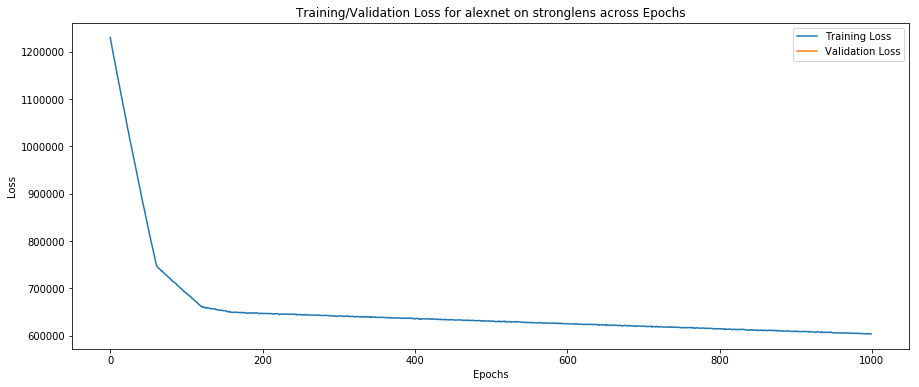

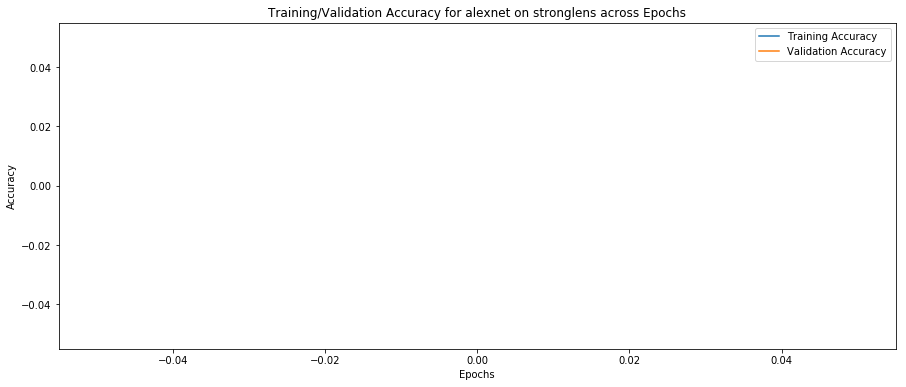

In [120]:
#@title
def plot_loss():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
  plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
  plt.title('Training/Validation Loss for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  
def plot_acc():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
  plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
  plt.title('Training/Validation Accuracy for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
plot_loss()
plot_acc()

In [121]:
def load_states():
  states = []
  for epoch in saved_epochs:
    filename = './checkpoint/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
    state = torch.load(filename)
    states.append(state)
  return states

states = load_states()

In [122]:
idx_interest = [0, 10, 20, 50, 100, 200, 500, 999]
nets = [state['net'] for idx, state in enumerate(states) if idx in idx_interest] #%1 == 0]
epochs = [state['epoch'] for idx, state in enumerate(states) if  idx in idx_interest] #%1 == 0]

In [133]:
def sample_predictive_epoch(feat, idx, n_iter=100000):
  batch_size = n_iter
  shape = feat.shape
  feat_rep = np.repeat(feat, batch_size, 0).reshape(batch_size, 1, resize, resize)
  if use_cuda:
        feat_rep.cuda()
  outs, kl, means, stds = nets[idx].probforward(feat_rep, ret_mean_std=True)
  outputs = outs.detach().cpu().numpy()
  #outputs = normalize(softplus(outs.detach().cpu().numpy()), axis=1, norm='l1')
  mn = means.detach().cpu().numpy()
  vn = (stds.detach().cpu().numpy() ** 2)
  confidence_mean = np.mean(outputs, axis=0)
  confidence_var = np.var(outputs, axis=0)
  epistemic = np.mean(mn ** 2, axis=0) - np.mean(mn, axis=0) ** 2 #np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
  aleatoric = np.mean(vn, axis=0)
  
  return outputs, confidence_mean, confidence_var, epistemic, aleatoric
  

In [138]:
def plot_epochs(feat, label, epochs, n_iter=1000):
    n_epochs = len(epochs)
    meanY = np.mean(trainY, axis=0)
    fig, ax = plt.subplots(nrows = n_epochs + 4, ncols = 5, figsize=(15, 5*n_epochs))
    means = np.zeros((outputs, n_epochs))
    vars = np.zeros((outputs, n_epochs))
    epistemics = np.zeros((outputs, n_epochs))
    aleatorics = np.zeros((outputs, n_epochs))
    bins = [np.linspace(0, 3, 100), np.linspace(-1, 1, 100), np.linspace(-1, 1, 100), np.linspace(-0.5, 0.5, 100), np.linspace(-0.5, 0.5, 100)]
    xlims = [[-0.5, 3], [-1, 1], [-1, 1,], [-0.5, 0.5], [-0.5, 0.5]]
    for i, epoch in enumerate(epochs):
        preds, m, v, ep, al = sample_predictive_epoch(feat, i, n_iter)
        means[:, i] = m
        vars[:, i] = v
        epistemics[:, i] = ep
        aleatorics[:, i] = al
        for j in range(outputs):
            lab = label[j]
            sns.distplot(preds[:, j], ax=ax[i, j], kde=False, bins=bins[j], label='Epoch {}'.format(epoch))
            ax[i, j].plot([lab, lab], [0, 1000], 'r-', linewidth=2) #, label='Target = {:.4f}'.format(lab)
            ax[i, j].plot([meanY[j], meanY[j]], [0, 1000], 'g-', linewidth=2) #, label='Mean(trainY) = {:.4f}'.format(meanY[j])
            ax[i, j].set_xlabel(output_names[j])
            ax[i, j].set_ylabel('hist count')
            ax[i, j].set_xlim(xlims[j])
            ax[i, j].set_xticks(np.arange(xlims[j][0], xlims[j][1], 0.75))
            ax[i, j].set_ylim(0, 100)
            ax[i, j].legend()
    
    estimates = [means, vars, epistemics, aleatorics]
    estimate_names = ['confidence_mean', 'confidence_var', 'epistemic uncertainty', 'aleatoric uncertainty']
    for i in range(n_epochs, n_epochs + 4):
        for j in range(outputs):
            idx = i - n_epochs
            sns.lineplot(x = epochs, y  = estimates[idx][j, :], ax=ax[i, j])
            ax[i, j].set_xlabel('#Epochs ({})'.format(output_names[j]))
            ax[i, j].set_ylabel(estimate_names[idx])
            ax[i, j].set_xticks(np.linspace(epochs[0], epochs[-1], 4))
    fig.suptitle('Sampled Predictive Distribution and estimates across Epochs.')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print('\n\nParameter Estiamtes with Uncertainties:\n\n')
    epochs_str = [str(ep) for ep in epochs]
    for j in range(outputs):
        print('Parameter: {}'.format(output_names[j]))
        pp_estimates(epochs_str, means[j, :], vars[j, :], epistemics[j, :], aleatorics[j, :], tag='Epoch #' )

In [125]:
dataloader = iter(testloader)

In [126]:
features, labels = dataloader.next()

In [127]:
labels[0].numpy()

array([ 1.0649  ,  0.29926 , -0.26354 , -0.005654,  0.06389 ],
      dtype=float32)

In [128]:
np.mean(trainY, axis=0)

array([1.4743139e+00, 9.6636324e-04, 5.3428747e-03, 5.2015265e-03,
       5.2140220e-03], dtype=float32)

In [129]:
print(epochs)

[0, 10, 20, 50, 100, 200, 500, 999]


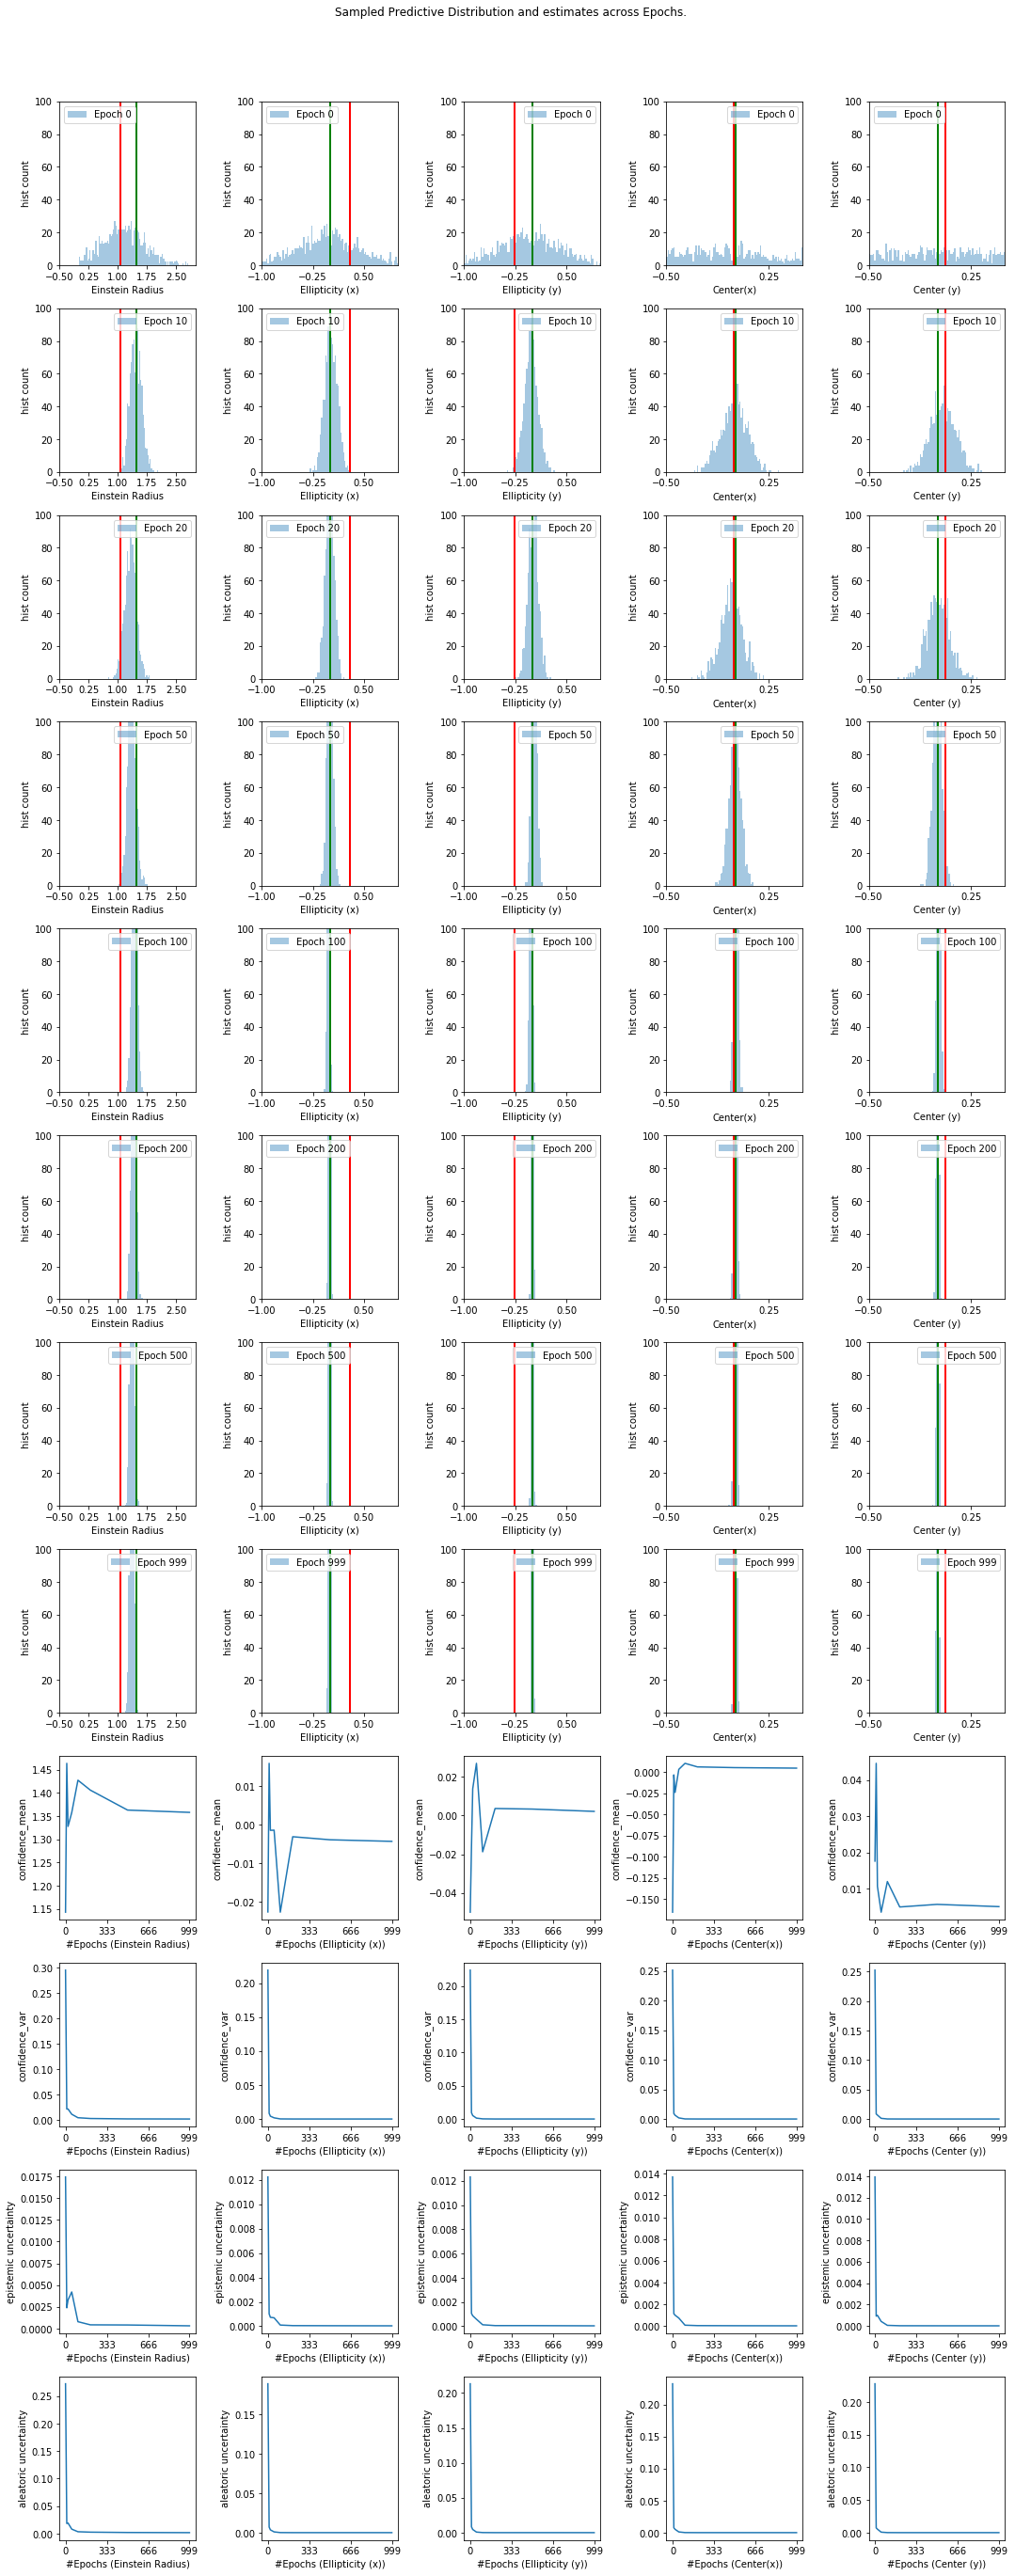



Parameter Estiamtes with Uncertainties:


Parameter: Einstein Radius


----------------------------------------------------------------------------------------------

|        Epoch #| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |

----------------------------------------------------------------------------------------------

|              0|           1.1428|    0.2951|                 0.0174|                 0.2725|

|             10|           1.4638|    0.0217|                 0.0024|                 0.0184|

|             20|           1.3278|    0.0219|                 0.0033|                 0.0193|

|             50|           1.3575|    0.0115|                 0.0042|                 0.0082|

|            100|           1.4274|    0.0047|                 0.0008|                 0.0035|

|            200|           1.4060|    0.0031|                 0.0004|                 0.0027|

|            500|           1.3630|    0.0023|                 

In [139]:
plot_epochs(features[0], labels[0].numpy(), epochs, n_iter=1000)

In [140]:
def get_predictions(dataloader):
    predsY = []
    for batch_idx, (inputs_value, targets) in enumerate(dataloader):
        x = inputs_value.view(-1, inputs, resize, resize)
        x_nobias = remove_image_intensity_bias(x)
        x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)
        predsY.extend(outs.detach().cpu().numpy())
    return np.array(predsY)

In [141]:
def scatter_plots():
    preds = get_predictions(testloader)
    #print(preds.shape)
    #print(testY.shape)
    #print(preds)
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
    points = [[0, 3], [-1, 1], [-1, 1], [-0.4, 0.4], [-0.4, 0.4]]
    
    for j in range(outputs):
        sns.scatterplot(x=testY[:, j], y=preds[:, j], ax=ax[j])
        ax[j].plot(points[j], points[j], '--r')
        ax[j].set_xlabel('{}: true'.format(output_names[j]))
        ax[j].set_ylabel('{}: predicted'.format(output_names[j]))
        ax[j].set_xlim(points[j])
        ax[j].set_ylim(points[j])
    fig.suptitle('Scatter plots for true vs predicted values for the parameters')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

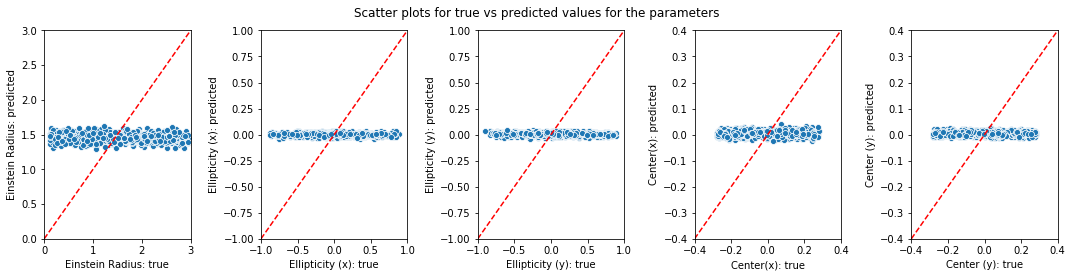

In [142]:
scatter_plots()

In [77]:
%debug

> <ipython-input-69-c0336f13eb8b>(7)pp_estimates()
      5     print(    '----------------------------------------------------------------------------------------------\n')
      6     for i in range(outputs):
----> 7         print('|{:>15s}|{:>17.4f}|{:>10.4f}|{:>23.4f}|{:>23.4f}|\n'.format(output_names[i], confidence_mean[i], confidence_var[i], epistemic[i], aleatoric[i]))
      8     print(    '----------------------------------------------------------------------------------------------\n\n')
      9 

ipdb> confidence_mean
0.6140528
ipdb> exit


# Next steps
- [ ] ~~Generate Training data from Galaxy Zoo and Great3 Images~~ (cant do it without matlab)
- [ ] Create Train, Val and Test set
- [ ] Adapt your code to deal with train/val/test instead of train/test
- [x] Track down the wierd behaviour of net returning 36 predictions per input.
- [ ] Add plots similar to Ensai notebook
- [ ] Create a Colab Notebook